# 🧪 Custom Gradient Boosting Classification

In this notebook, we implement gradient boosting on decision trees **from scratch**. We then compare the performance of these implementations with **scikit-learn**'s `GradientBoostingClassifier`, `DecisionTreeClassifier` and **XGBoost**'s `XGBClassifier` models.

### ⚙️ Importing Libraries & Environment Setup

In [87]:
from math import ceil
from typing import Any, Literal

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from numpy.random import Generator as RandomGenerator
from numpy.typing import NDArray
from sklearn.datasets import make_circles
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
)
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from xgboost import XGBClassifier

In [88]:
%matplotlib inline

pd.set_option("display.width", 150)
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", None)

### 🧰 Utility Functions

In [89]:
def evaluate_classification_models(
    predictions: dict[str, NDArray[np.float64]], y: NDArray[np.float64]
) -> pd.DataFrame:
    """Evaluate multiple classification model predictions on the provided dataset.

    Args:
        predictions (dict[str, NDArray[np.float64]]): Dictionary mapping model names
            to predicted target arrays (binary or probabilities) for the dataset.
        y (NDArray[np.float64]): True binary target values of shape (n_samples,).

    Returns:
        pd.DataFrame: DataFrame containing classification metrics — Accuracy, Precision,
            Recall, F1-score, and ROC AUC — for each model. Columns correspond to
            model names, rows correspond to the metric names.
    """
    evaluations = pd.DataFrame(
        columns=predictions.keys(),
        index=["Accuracy", "Precision", "Recall", "F1-score", "ROC AUC"],
    )

    for name, y_pred in predictions.items():
        accuracy = accuracy_score(y, y_pred)
        precision = precision_score(y, y_pred)
        recall = recall_score(y, y_pred)
        f1 = f1_score(y, y_pred)
        roc_auc = roc_auc_score(y, y_pred)

        evaluations.loc[:, name] = [accuracy, precision, recall, f1, roc_auc]

    return evaluations.astype(float)

In [90]:
def plot_confusion_matrices(
    predictions: dict[str, NDArray[np.int64]],
    y_true: NDArray[np.int64],
    n_cols: int = 2,
) -> None:
    """Plot confusion matrices for multiple classification models.

    Each confusion matrix compares the true labels to predictions from one model.
    The plots are arranged in a grid layout for easy comparison.

    Args:
        predictions (dict[str, NDArray[np.int64]]): A dictionary mapping model names to
            their predicted labels (1D array of shape (n_samples,)).
        y_true (NDArray[np.int64]): True class labels (1D array of shape (n_samples,)).
        n_cols (int, optional): Number of columns in the subplot grid layout.
            Default is 2.
    """
    n_models = len(predictions)
    n_cols = min(n_models, n_cols)
    n_rows = ceil(n_models / n_cols)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 5 * n_rows))
    axes = np.array(axes).reshape(-1)

    for ax, (name, y_pred) in zip(axes, predictions.items(), strict=False):
        conf_matrix = confusion_matrix(y_true, y_pred)
        sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax)
        ax.set_xlabel("Predicted Labels")
        ax.set_ylabel("True Labels")
        ax.set_title(name)

    for i in range(n_models, len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()

In [91]:
def plot_decision_tree_boundaries(
    models: dict[str, Any],
    X_train: NDArray[np.float64],
    y_train: NDArray[np.float64],
    n_cols: int = 2,
) -> None:
    """Visualize decision boundaries of trained decision tree models.

    Args:
        models (dict[str, Any]): Dictionary of trained models with `.predict` method.
        X_train (NDArray[np.float64]): Training features of shape (n_samples, 2).
        y_train (NDArray[np.float64]): Training labels of shape (n_samples,).
        n_cols (int): Number of columns in subplot grid.
    """
    x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300), np.linspace(y_min, y_max, 300))
    grid = np.c_[xx.ravel(), yy.ravel()]

    n_models = len(models)
    n_cols = min(n_models, n_cols)
    n_rows = ceil(n_models / n_cols)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 5 * n_rows))
    axes = np.array(axes).reshape(-1)

    for ax, (name, model) in zip(axes, models.items(), strict=False):
        Z = model.predict(grid).reshape(xx.shape)

        ax.contourf(xx, yy, Z, alpha=0.3, cmap="Set1")
        sns.scatterplot(
            x=X_train[:, 0], y=X_train[:, 1], c=y_train, cmap="Set1", alpha=0.5, ax=ax
        )
        ax.set_xlabel("Feature 1")
        ax.set_ylabel("Feature 2")
        ax.set_title(name)

    for i in range(n_models, len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()

### 📥 Loading the Dataset

In [92]:
# Generate dataset
X, y = make_circles(n_samples=300, noise=0.05, factor=0.5, random_state=0)

In [93]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

### 🧠 Implementing Custom Model Algorithms

In [94]:
class MyGBDTClassifier:
    """Gradient Boosted Decision Tree classifier for binary classification.

    This classifier builds an ensemble of decision trees sequentially, where
    each new tree attempts to correct the errors of the previous ensemble by
    fitting to the residuals (negative gradients) of the logistic loss function.
    Supports regularization, feature subsampling, and optional binning for split
    thresholds.

    Attributes:
        learning_rate (float): Shrinkage factor applied to each tree's contribution.
        n_estimators (int): Number of boosting iterations (trees).
        criterion (str): Function to measure split quality
            ("squared_error", "friedman_mse", "absolute_error", "poisson").
        splitter (str): Strategy used to choose the split at each node: "best"
            or "random".
        max_depth (int | None): Maximum depth allowed for each tree.
        min_samples_split (int | float): Minimum samples required to split an
            internal node.
        min_samples_leaf (int | float): Minimum samples required to be present at
            a leaf node.
        min_weight_fraction_leaf (float): Minimum fraction of samples required at
            a leaf node.
        max_features (int | float | str | None): Number or method of feature
            selection per split ("auto", "sqrt", "log2", or None).
        max_leaf_nodes (int | None): Maximum number of leaf nodes per tree.
        min_impurity_decrease (float): Minimum impurity decrease required
            to make a split.
        bootstrap (bool): Whether samples are drawn with replacement.
        ccp_alpha (float): Complexity parameter used for Minimal Cost-Complexity
            Pruning.
        rng (np.random.Generator): Random number generator instance.
        trees (list[MyDecisionTreeRegressor]): List of fitted regression trees.
        F0 (float | None): Initial prediction log-odds before any boosting.
    """

    def __init__(
        self,
        learning_rate: float,
        n_estimators: int,
        criterion: Literal[
            "squared_error", "friedman_mse", "absolute_error", "poisson"
        ] = "squared_error",
        splitter: Literal["best", "random"] = "best",
        max_depth: int | None = None,
        min_samples_split: int | float = 2,
        min_samples_leaf: int | float = 1,
        min_weight_fraction_leaf: float = 0.0,
        max_features: int | float | Literal["auto", "sqrt", "log2"] | None = None,
        max_leaf_nodes: int | None = None,
        min_impurity_decrease: float = 0.0,
        bootstrap: bool = True,
        random_state: int | None = None,
        ccp_alpha: float = 0.0,
    ) -> None:
        """Initialize the Random Forest classifier with hyperparameters.

        Args:
            learning_rate (float): Step size shrinkage applied to each tree's output.
            n_estimators (int): Number of trees in the forest.
            criterion (str): Function to measure split quality
                ("squared_error", "friedman_mse", "absolute_error", "poisson").
            splitter (str): Strategy used to choose the split at each node:
                "best" or "random".
            max_depth (int | None): Maximum depth of each tree.
            min_samples_split (int | float): Minimum samples needed to split a node.
            min_samples_leaf (int | float): Minimum samples needed in a leaf node.
            min_weight_fraction_leaf (float): Minimum weighted fraction needed in a
                leaf.
            max_features (int | float | str | None): Number or method of feature
                selection per split ("auto", "sqrt", "log2", or None).
            max_leaf_nodes (int | None): Maximum number of leaf nodes per tree.
            min_impurity_decrease (float): Threshold for impurity reduction to
                split nodes.
            bootstrap (bool): Whether to use bootstrap sampling.
            random_state (int | None): Seed for reproducibility.
            ccp_alpha (float): Complexity parameter for pruning.
        """
        self.learning_rate = learning_rate
        self.n_estimators = n_estimators
        self.criterion = criterion
        self.splitter = splitter
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.min_weight_fraction_leaf = min_weight_fraction_leaf
        self.max_features = max_features
        self.max_leaf_nodes = max_leaf_nodes
        self.min_impurity_decrease = min_impurity_decrease
        self.bootstrap = bootstrap
        self.ccp_alpha = ccp_alpha

        self.rng: RandomGenerator = np.random.default_rng(random_state)
        self.trees: list[DecisionTreeClassifier] = []
        self.F0: DecisionTreeClassifier | None = None

    def _sigmoid(self, z: NDArray[np.float64]) -> NDArray[np.float64]:
        """Compute the sigmoid activation function.

        Args:
            z (NDArray[np.float64]): Input array (can be a scalar, vector, or matrix).

        Returns:
            NDArray[np.float64]: Output after applying the sigmoid function.
        """
        return 1 / (1 + np.exp(-z))

    def _compute_initial_logit(self, y: NDArray[np.int64]) -> float:
        """Calculate the initial log-odds of the positive class.

        Args:
            y (NDArray[np.int64]): Binary target labels.

        Returns:
            float: Initial prediction in log-odds space.
        """
        p = np.clip(np.mean(y), 1e-5, 1 - 1e-5)
        return np.log(p / (1 - p))

    def _compute_gradient(
        self, y_true: NDArray[np.int64], y_pred_logit: NDArray[np.int64]
    ) -> NDArray[np.float64]:
        """Compute the gradient of the logistic loss.

        Args:
            y_true (NDArray[np.int64]): True binary labels.
            y_pred_logit (NDArray[np.float64]): Current predictions in log-odds space.

        Returns:
            NDArray[np.float64]: Residuals (negative gradients) for boosting.
        """
        prob = self._sigmoid(y_pred_logit)
        return y_true - prob

    def fit(self, X: NDArray[np.float64], y: NDArray[np.int64]) -> None:
        """Fit the Gradient Boosted Decision Tree classifier to training data.

        Args:
            X (NDArray[np.float64]): Training features, shape (n_samples, n_features).
            y (NDArray[np.int64]): Binary target labels, shape (n_samples,).
        """
        self.F0 = self._compute_initial_logit(y)
        Fm = np.full_like(y, self.F0, dtype=np.float64)
        self.trees.clear()

        for _ in range(self.n_estimators):
            residuals = self._compute_gradient(y, Fm)

            tree = DecisionTreeRegressor(
                criterion=self.criterion,
                splitter=self.splitter,
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split,
                min_samples_leaf=self.min_samples_leaf,
                min_weight_fraction_leaf=self.min_weight_fraction_leaf,
                max_features=self.max_features,
                max_leaf_nodes=self.max_leaf_nodes,
                min_impurity_decrease=self.min_impurity_decrease,
                ccp_alpha=self.ccp_alpha,
                random_state=self.rng.integers(1_000_000),
            )
            tree.fit(X, residuals)
            self.trees.append(tree)

            Fm += self.learning_rate * tree.predict(X)

    def predict(self, X: NDArray[np.float64]) -> NDArray[np.int64]:
        """Predict binary class labels for input samples.

        Args:
            X (NDArray[np.float64]): Input features, shape (n_samples, n_features).

        Returns:
            NDArray[np.int64]: Predicted binary class labels.
        """
        Fm = np.full(X.shape[0], self.F0, dtype=np.float64)
        for tree in self.trees:
            Fm += self.learning_rate * tree.predict(X)
        prob = self._sigmoid(Fm)
        return (prob >= 0.5).astype(int)

### 🏋️‍♂️ Model Training

In [95]:
# Scikit-learn decision tree classifier model
sklearn_model_tree = DecisionTreeClassifier(max_depth=2, random_state=42)
sklearn_model_tree.fit(X_train, y_train)

# Scikit-learn gradient boosting classifier model
sklearn_model = GradientBoostingClassifier(
    learning_rate=0.1, n_estimators=20, max_depth=2, random_state=42
)
sklearn_model.fit(X_train, y_train)

# XGBoost classifier model
xgb_model = XGBClassifier(
    learning_rate=0.1, n_estimators=20, max_depth=2, random_state=42
)
xgb_model.fit(X_train, y_train)

# My gradient boosting classifier model
my_model = MyGBDTClassifier(
    learning_rate=0.1, n_estimators=20, max_depth=2, random_state=42
)
my_model.fit(X_train, y_train)

### 📊 Comparing Algorithm Versions

In [96]:
predictions = {
    "scikit-learn_tree": sklearn_model_tree.predict(X_test),
    "scikit-learn": sklearn_model.predict(X_test),
    "xgboost": xgb_model.predict(X_test),
    "my": my_model.predict(X_test),
}

models = {
    "scikit-learn_tree": sklearn_model_tree,
    "scikit-learn": sklearn_model,
    "xgboost": xgb_model,
    "my": my_model,
}

In [97]:
evaluate_classification_models(predictions, y_test)

,scikit-learn_tree,scikit-learn,xgboost,my
Accuracy,0.733333,1.0,0.983333,1.0
Precision,0.589744,1.0,1.000000,1.0
Recall,1.000000,1.0,0.956522,1.0
F1-score,0.741935,1.0,0.977778,1.0
ROC AUC,0.783784,1.0,0.978261,1.0


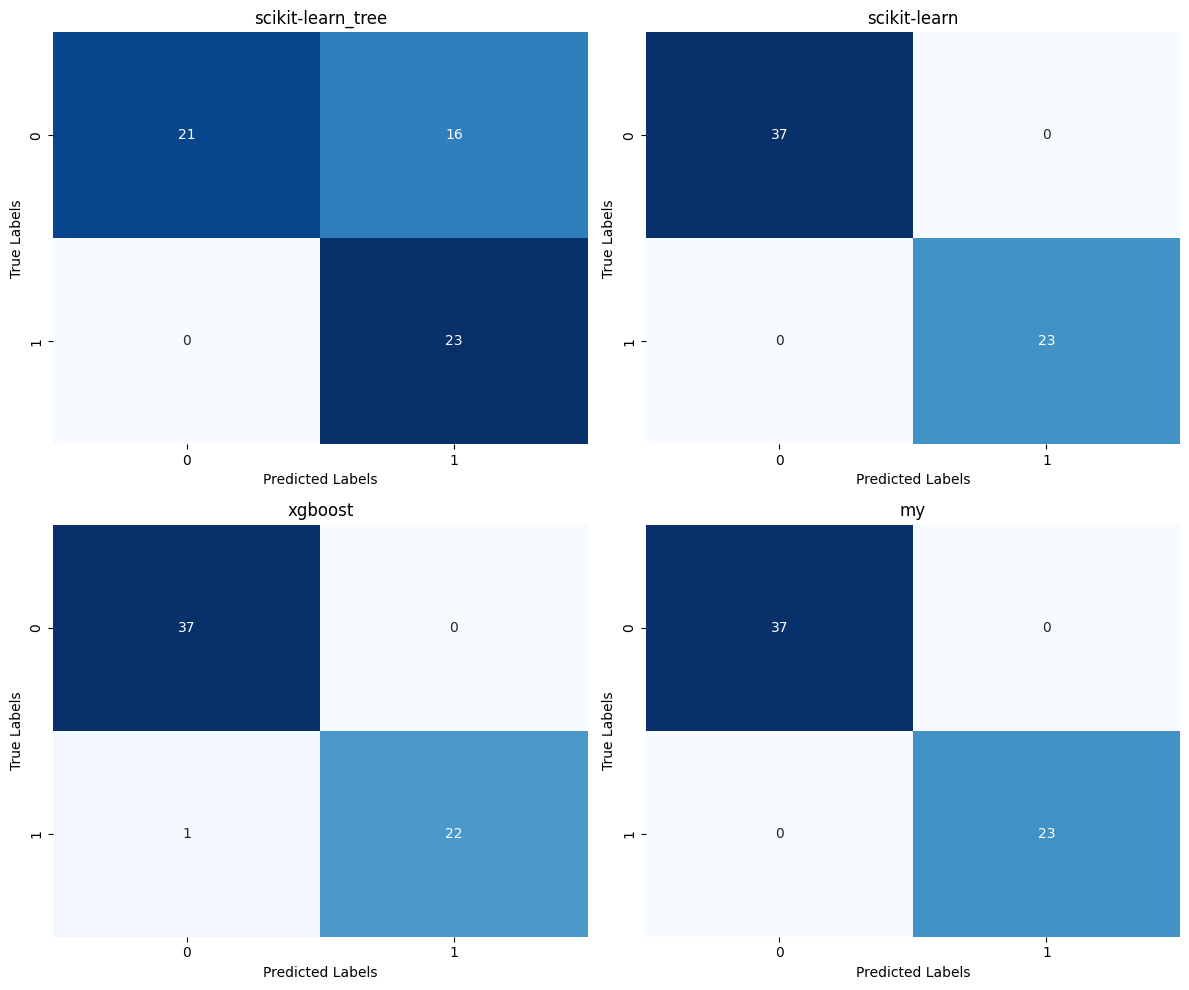

In [98]:
plot_confusion_matrices(predictions, y_test)

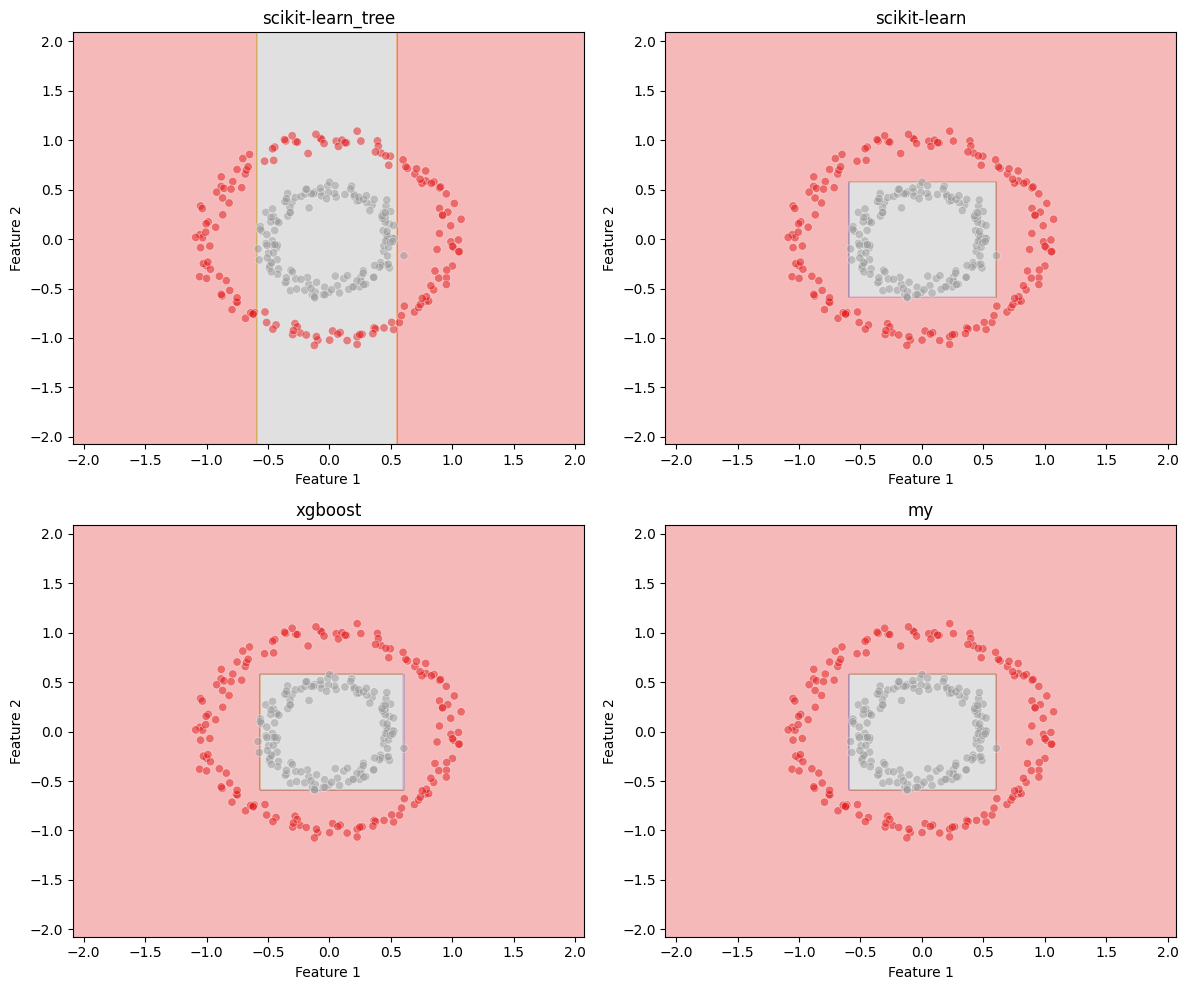

In [99]:
plot_decision_tree_boundaries(models, X, y)